In [ ]:
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import seaborn as sb
from IPython.display import HTML
from IPython import display
from ipywidgets import FloatSlider
from scipy.integrate import odeint
from scipy.interpolate import interp1d
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 120

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os


os.chdir('/content/drive/Shareddrives/Dollar Research Group/Scripts_and_Code/Protons')

Mounted at /content/drive


Proton stopping distance calculator & RCF stack builder

In [ ]:
# @title RCF Stack Class
class RCF_stack:


  #initializes a stack of materials for the RCF stack and computes
  #total thickness, number of layers, material names, and cumulative thickness
  def __init__ (self, stack):

      self.stack = stack.copy()
      i = 0
      while i < len(self.stack):
        if self.stack[i] == ['HD']:
          self.stack.insert(i, ['poly', 0.0097])
          self.stack.insert(i, ['poly_active', 0.0012])
          self.stack.pop(i+2)
        i+=1


      #combines the list together to create a total thickness
      self.total_thickness = sum([layer[1] for layer in self.stack])
      #gets materials in each layer
      self.materials = [layer[0] for layer in self.stack]
      #gets
      self.num_layers = len(self.stack)
      #gets thicknesses of each layer
      self.thickness = [layer[1] for layer in self.stack]
      #cumulative thickness
      self.cumu_thickness = np.cumsum(self.thickness)
      #dictionary for the densities of materials that are being used
      self.densities = {
          'poly': 1.38,
          'Al': 2.7,
          'Fe': 7.874,
          'Ur': 19.05,
          'poly_active': 1.38,
          'pvt': 0.15
      }

      self.HD_total_thick = 0.0097 + 0.0012
      self.HD_active_thick = 0.0012
      self.HD_substrate_thick = 0.0097

      #stores inerpolating functions for different materials later in the code
      self.interpolators = {}
      #Loads data and sets up the interpolating functions
      self._do_imports_interpolations()


  #Gets the stopping power for each material in the stack and creates an
  #interpolating function
  def _do_imports_interpolations(self):
    for material in set(self.materials):
      if material == 'poly' or material == 'poly_active':
        data = np.genfromtxt('poly.txt', delimiter = ' ', skip_header = 8, usecols = (0,1))
        KE = data[:, 0]
        SP = data[:, 1]*self.densities['poly']
      elif material == 'Al':
        data = np.genfromtxt('al.txt', delimiter = ' ', skip_header = 8, usecols = (0,1))
        KE = data[:, 0]
        SP = data[:, 1]*self.densities['Al']
      elif material == 'Fe':
        data = np.genfromtxt('fe.txt', delimiter = ' ', skip_header = 8, usecols = (0,1))
        KE = data[:, 0]
        SP = data[:, 1]*self.densities['Fe']
      elif material == 'pvt':
        data = np.genfromtxt('pvt.txt', delimiter = ' ', skip_header = 8, usecols = (0,1))
        KE = data[:,0]
        SP = data[:,1]*self.densities['pvt']
      else:
        #If there is a layer in the stack that is not any
        #of the materials above.
        print('layer material not recognized: ', material)
      #print('before interp')
      self.interpolators[material] = interp1d(KE, SP, kind = 'cubic')
      #print('after interp')




  def get_colors(self, material):
    #dictionary of colors for each material for plotting
    colors = {
        'Al': 'gray',
        'poly': 'orange',
        'Fe': 'green',
        'poly_active': 'red',
        'pvt': 'blue'
    }
    #tries to look up the color for the given material that is
    #not a part of the colors dictionary
    try:
      plot_color = colors[material]
      #if the material is not found in the dictionary it accepts
      #the error and makes the default color white for
      #the unrecognized material
    except KeyError:
      print('invalid material type ', material)
      return 'white'
      #If the material is found in the colors dictionary,
      #it will return the color that is associated
      #with the recognized material
    else:
      return plot_color


  def get_int_func(self, layer_ind):
    #returns the stopping power integral for each material that were defined earlier

    return self.interpolators[self.materials[layer_ind]]


  def get_thickness(self, layer_ind):
    return self.thickness[layer_ind]
    # inputs: index of layer that we want to get thicness of
    # outputs: thickness of specified layer in cm



In [ ]:
# @title Main Methods
def stack_stop(stack, energy, dx=0.001):
  #Euler method
  e = energy
  stopping_dist = 0
  d = 0
  de = 0
  # calculate energy loss one layer in the stack at a time
  #for i in stack.getlayers:
  #  int_fn = stack.get_intfn(i)

  for i in range(stack.num_layers):
    int_fn = stack.get_int_func(i)


    d = 0
    # Euler method to track proton energy. Stops when proton stops or gets to the next layer
    while not(de > e or e < 0.001 or d >= stack.get_thickness(i)):
      d += dx
      de = dx * int_fn(e)[()]
      e -= de

    if d >= stack.get_thickness(i):
      d = stack.get_thickness(i)

    stopping_dist += d

    #if e < 0.001:
      #break



  return stopping_dist #e




#calculates how far the protons travel into a stack with
#different materials before they stop and collects those
#distances in the list "stop"

def energy_bands(stack, energies, dx = 0.001):
  #stores stopping distances
  stop = []
  #total thickness of the stack
  total = stack.total_thickness

  #loops through every proton energy
  for en in energies:
    ss = stack_stop(stack, en, dx)
    #if the stopping distance of a proton is greater than
    #the total thickness of the stack, the loop breaks
    if ss >= total:
      break
    stop.append([ss])
  #returns the list of stopping distances that were collected in the "stop" list
  return stop

#Energy vs. range plot that shows where each given material in the stack is located.
#Plots proton traval distances/stopping ranges of protons with varying energy levels
#within the different materials in the stack
def plot_bands(stack, energies, bands, show_legend = False, name = " "):
  #converts units of distance from cm to μm
  x = np.array([i[0] * 10**4 for i in bands])
  y = energies[:len(bands)]
  #layer thickness
  stackdims = np.array(stack.thickness)
  #a list of thicknesses of each layer, and tells where each layer starts and ends
  endpoints = [np.sum(stackdims[:i]) * 10**4 for i in range(len(stackdims)+1)]
  fig, ax = plt.subplots()

  for i in range(len(endpoints)-1):
    material = stack.materials[i]
    col = stack.get_colors(material)

    ax.fill_betweenx(y, endpoints[i], endpoints[i+1], color=col, label=material+' '+'{:.2f}'.format(stack.thickness[i]*1e4) + '$\mu m$')
    #if show_layers: fig.text(0.92, 0.8 - 0.05*i, '{}'.format(stack.materials[i]))

  #plots energy vs. range data with black points
  ax.scatter(x, y, color='black')
  #ax.legend(handles=list(legend_elements.values()), title = "Materials")
  #labels the x axis
  ax.set_xlabel('Range [$\mu$m]', fontsize =12)
  #labels the y axis
  ax.set_ylabel('Energy [MeV]',fontsize=12)
  #sets the title of the plot
  ax.set_title('Stopping range for {}'.format(name if name != "" else 'stack'))
  #plots legend outside of the plot
  if show_legend is True:
    ax.legend(bbox_to_anchor=(1.1, 1.05))
  #shows the plot
  plt.show()








#computes the energy ranges that belong to each layer in the given stack
def energy_bins(stack, energies, bands):
  #maps spatial posiitons from bands into energy values

  intfn = interp1d(np.array(bands).reshape([len(bands),]), energies[:len(bands)], kind='cubic')
  #starting at 0 which represents the start of the first layer
  cs = np.append([0],stack.cumu_thickness)
  #looping through the given layers
  ranges = []
  for i in range(stack.num_layers):
    if i == 0:
      emin=0
    else:
      emin = intfn(cs[i])
    if i == stack.num_layers - 1:
      emax = energies[-1]
    else:
      try:
        emax = intfn(cs[i+1])
      except ValueError:
        print('Final energy stops within stack')
        emax = energies[-1]
        ranges.append([emin,emax])
        break
    ranges.append([emin,emax])

    #print('Layer', i+1, 'bin is', emin,'-',emax)
  return np.array(ranges)



#bar graph for energy bins
def plot_energy_bins(stack, energies, bands, orientation = 'vertical'):
  ranges = energy_bins(stack, energies, bands)
  num_layers = len(ranges)
  x = np.arange(num_layers)
  plt.figure(figsize = (10,6))

  if orientation == 'vertical':
    x = np.arange(num_layers)
    #calculates the height of each bar
    heights = ranges[:,1] - ranges[:,0]
    #where the bottom of each bar should start
    bottoms = ranges[:,0]
    midpoints = (ranges[:,0] + ranges[:,1]) / 2


    plt.bar(x, heights, bottom=bottoms, width=0.6, color = 'blue')


    for i in range(num_layers):
      midpoint_label = f"{midpoints[i]:.2f}"
      label = f"{ranges[i,0]:.2f}-{ranges[i,1]:.2f} MeV"
      plt.text(x[i], ranges[i, 1] + 0.1, midpoint_label,
               ha = 'center', va = 'bottom', fontsize = 8, color = 'black')


    plt.xlabel('Layers')
    plt.ylabel('Energy (MeV)')
    plt.title('Energy Bins for Each Layer in Stack')
    plt.xticks(x)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(np.min(ranges)-0.5, np.max(ranges) + 0.5)
    plt.show()






#### Optimizer function
## Inputs: Energy ranges to capture, number of RCF layers to use
## Outputs: Stack object, arranged to capture provided energy values
## stack_builder(5, [1, 4, 7, 10, 15])
def stack_builder(n_RCF, energy_vals, dx=0.0001):
  #start with aluminum that stops everything before the first desired detectable energy


  infinity = sys.float_info.max
  init_stack = [['Al', infinity]] # "infinite" Aluminum block
  stack = RCF_stack(init_stack)

  std = stack_stop(stack, energy_vals[0], dx = dx)
  #This will add the Alumninum layer of the right thickness
  new_stack = [['Al', std],['HD']]
  test_stack = new_stack + [['HD']]



### test stack


  #keep looping as long as long as the number of RCF layers is less than
  #the maximum (n_RCF) and we still have more energy values in energy_vals
  #to loop through
  i=1
  while len([layer for layer in new_stack if layer[0] == 'HD']) < n_RCF and i < len(energy_vals):
    E = energy_vals[i]

    #original stack before adding more layers
    original_stack = RCF_stack(new_stack)
    stop_original = stack_stop(original_stack, E, dx = dx)

    #test adds one more HD layer
    test_stack = new_stack + [['HD']]
    test_stack_obj = RCF_stack(test_stack)
    stop_test = stack_stop(test_stack_obj, E, dx = dx)


    # check if current energy stops in current stack
    if stop_original <= original_stack.total_thickness :
      i +=1
    elif stop_test <= test_stack_obj.total_thickness - test_stack_obj.HD_substrate_thick :
      new_stack = new_stack + [['HD']]
      i+=1
    else:
      sta = stack_stop(RCF_stack(new_stack + [['Al', infinity]]), E)
      thAl = sta - original_stack.total_thickness
      new_stack = new_stack + [['Al', thAl]] + [['HD']]
      i+=1

    #if energy level deeper in the test stack then in the original stack
    #and if it stops inside the new RCF layer we just added then it will
    #add the new RCF layer in the stack
    #add_layer = test_stack_obj.total_thickness - stop_test
    #if stop_test > stop_original and add_layer <= original_stack.HD_total_thickness:
    #  new_stack.append(['HD'])
      #move to the next energy level that was inputed
    #  i += 1
    #else:
    #  break


#  i=1
#  for en in energy_vals[i:]:
#    t_RCF_stack = RCF_stack(test_stack)
#    std = stack_stop(t_RCF_stack, energy_vals[i], dx=dx)
#    if std >= stack.total_thickness :
#      new_stack.append(['Al', infinity])
#      stack = RCF_stack(new_stack)
#      break

   # elif: std > 2*stack.HD_total_thick and std <= stack.HD_total_thick:
      #new_stack.append(['Al', infinity])
      #stack = RCF_stack(new_stack)
      #break


#    elif: std >= stack.total_thickness - HD_substrate_thick:
#      new_stack.append(['HD'])
#      stack = RCF_stack(new_stack)
#      break


#    elif: std >= stack.total_thickness - HD_substrate_thick - HD_active_thick:
#      new_stack.append(['Al', inifinity])
#      stack = RCF_stack(new_stack)
#      break

#    elif: std >= stack.total_thicknes - HD_active_thick - 2*HD_substrate_thick:
#      new_stack.append(['HD'])
#      stack = RCF_stack(new_stack)
#      break

#    elif: std >= stack.total_thickness - 2*HD_active_thick - 2*HD_substrate_thick:
    #  new_stack.append(['HD'])
    #  stack = RCF_stack(new_stack)
#      break


#    else:
#      test_stack.append(['HD'])
#      new_stack.append(['HD'])
#      stack = RCF_stack(test_stack)
#      i+=1
#  std = stack_stop(stack, energy_vals[0], dx = dx)


#  rcf_count = [0]
#  i = [0]

#  while rcf_count < n_RCF and i < len(energy_vals):
    #Adds am RCF layer
    #HD --> poly + poly_active
 #   new_stack.append(['HD'])

  #using first provided E val, propagate through aluminum and see how much thickness you need to stop that E val
    # make a stack with a comically thick single layer of aluminum
    # std = stackstop(first energy)
    # replace original stack with a new one, first aluminum layer with thickness = std
  #add an rcf layer to the stack
    # append ['HD'] to the stack
    # remake stack
  #check if the next energy also stops in this rcf layer
    # run stackstop(second energy) using the updated stack
  #if not, add more aluminum
  return new_stack


###scintillator
def PVT_stack_builder(energy_vals, thickness=0.015, dx=0.0001, e_error=0, n_det_layers=None):
  #start with aluminum that stops everything before the first desired detectable energy


  infinity = sys.float_info.max

  if n_det_layers is None:
    n_det_layers = infinity

  init_stack = [['Al', infinity]] # "infinite" Aluminum block
  stack = RCF_stack(init_stack)

  std = stack_stop(stack, energy_vals[0], dx = dx)
  #This will add the Alumninum layer of the right thickness
  new_stack = [['Al', std],['pvt', thickness]]
  test_stack = new_stack + [['pvt', thickness]]



### test stack


  #keep looping as long as long as the number of RCF layers is less than
  #the maximum (n_RCF) and we still have more energy values in energy_vals
  #to loop through
  i=1
  while len([layer for layer in new_stack if layer[0] == 'pvt']) < n_det_layers and i < len(energy_vals):
    E = energy_vals[i]

    #original stack before adding more layers
    original_stack = RCF_stack(new_stack)
    stop_original = stack_stop(original_stack, E, dx = dx)

    #test adds one more HD layer
    test_stack = new_stack + [['pvt', thickness]]
    test_stack_obj = RCF_stack(test_stack)
    stop_test = stack_stop(test_stack_obj, E, dx = dx)


    # check if current energy stops in current stack
    if stop_original < original_stack.total_thickness :
      print('first')
      i +=1
    elif stop_test < test_stack_obj.total_thickness : #E doesn't stop in current stack, but would stop if we added immediate PVT layer
      print('second')
      new_stack = new_stack + [['pvt', thickness]]
      i+=1
    else:
      print('third')
      sta = stack_stop(RCF_stack(new_stack + [['Al', infinity]]), E*(1-e_error))
      print(sta)
      thAl = sta - original_stack.total_thickness
      new_stack = new_stack + [['Al', thAl]] + [['pvt',thickness]]
      i+=1






  return new_stack + [['Al',0.001]]


In [ ]:
sb = PVT_stack_builder([1, 3.25, 5, 7, 9, 13, 18], dx=0.00001)
sb_stack = RCF_stack(sb) #e_error=0.015))

en = np.hstack([np.linspace(0, 7, 125*7//5), np.linspace(7,13,700)[1:], np.linspace(13,20,1000)[1:]])
#en = np.linspace(0,6,300)
bands = energy_bands(sb_stack, en, dx=0.00001)
#plot_bands(sb_stack, en, bands, show_legend = True, name = "Scintillator stack")

third
0.023450000000000002
third
0.04645
third
0.07545
third
0.10845000000000002
third
0.16845000000000004
third
0.2594500000000001


[[ 0.          0.990859  ]
 [ 0.990859    1.56096733]
 [ 1.56096733  3.31389001]
 [ 3.31389001  3.60325507]
 [ 3.60325507  4.93019882]
 [ 4.93019882  5.16550495]
 [ 5.16550495  6.97655876]
 [ 6.97655876  7.15183121]
 [ 7.15183121  9.04760573]
 [ 9.04760573  9.18658437]
 [ 9.18658437 12.95079644]
 [12.95079644 13.05553375]
 [13.05553375 17.96442343]
 [17.96442343 18.047035  ]
 [18.047035   20.        ]]


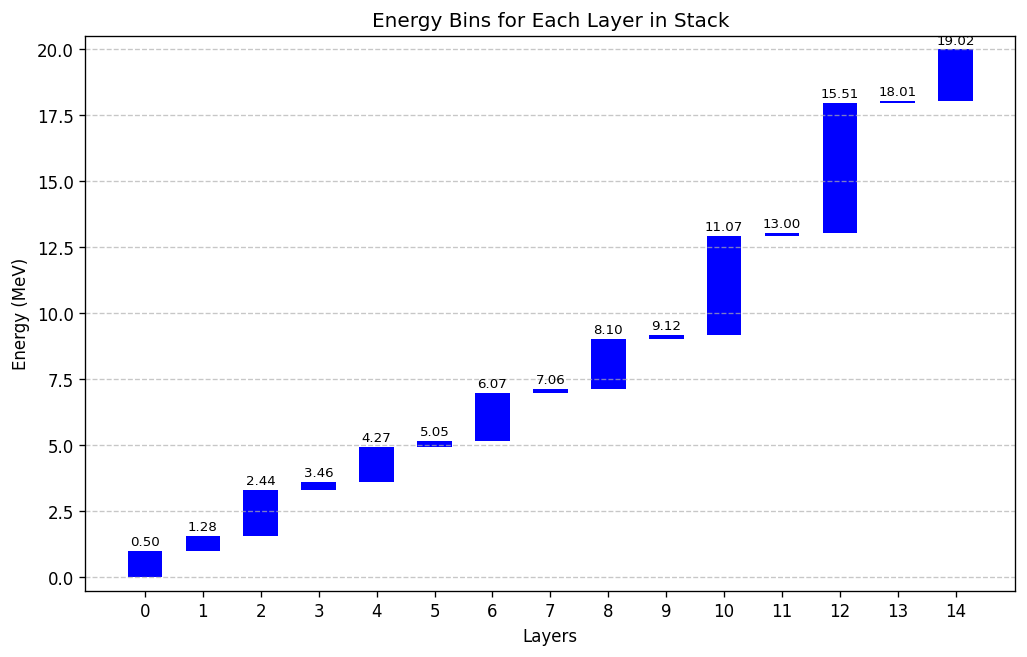

In [ ]:
print(energy_bins(sb_stack, en, bands))

plot_energy_bins(sb_stack, en, bands, orientation='vertical')

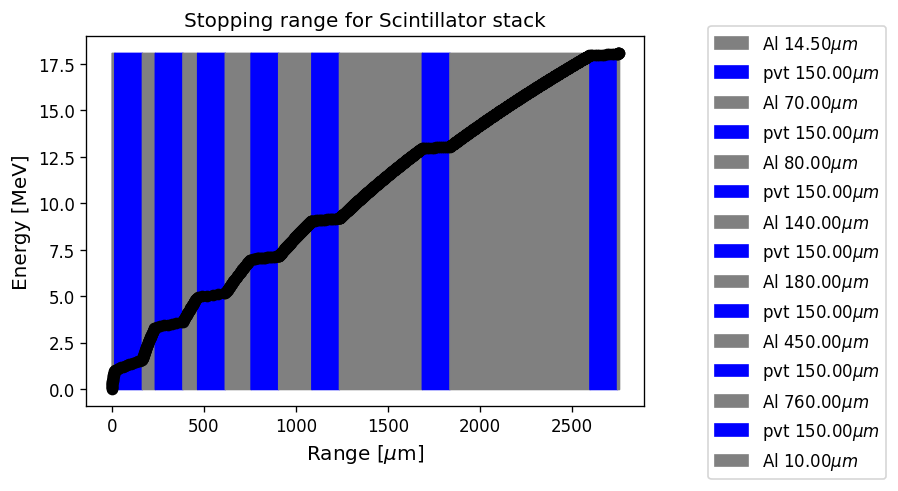

In [ ]:
plot_bands(sb_stack, en, bands, show_legend = True, name = "Scintillator stack")

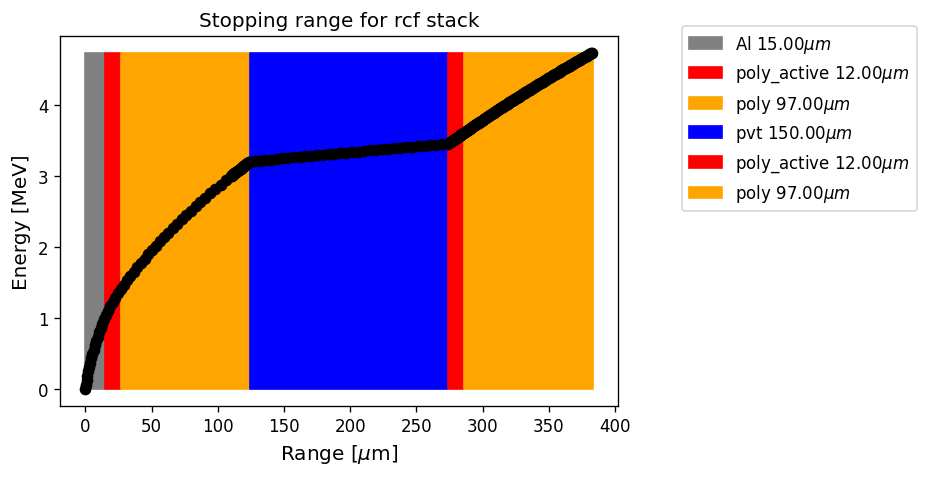

In [ ]:
tt_stack = [['Al', 0.0015000000000000005],
 ['HD'],['pvt', 0.015], ['HD']]

ttR_stack = RCF_stack(tt_stack)

en = np.hstack([np.linspace(0, 3, 50), np.linspace(3, 6, 400)[1:]])
bands = energy_bands(ttR_stack, en, dx=0.00001)

plot_bands(ttR_stack, en, bands, show_legend = True, name = "rcf stack")

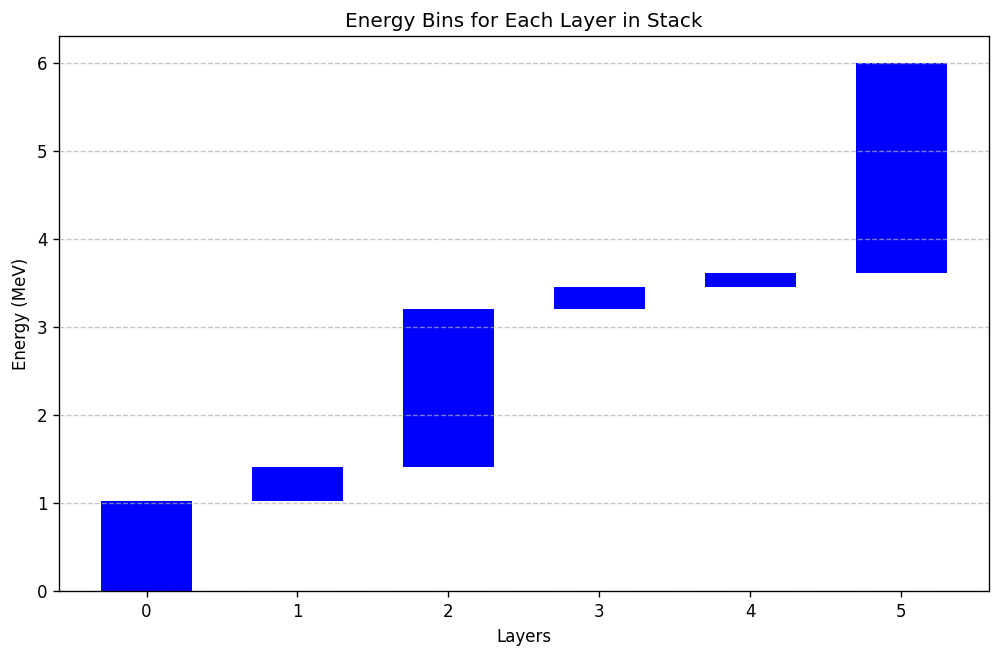

In [ ]:
energy_bins(ttR_stack, en, bands)

plot_energy_bins(ttR_stack, en, bands, orientation='vertical')




In [ ]:
#list materials of choice to create a stack
s_params_test = [['Al',0.00125], ['HD'], ['HD'],['HD'],['HD']]#,['HD'],['HD'],['HD'],['HD'],['HD'],['HD'],['HD']]
#initializes created stack into the RCF_stack class
my_stack = RCF_stack(s_params_test)

0.028000000000000004


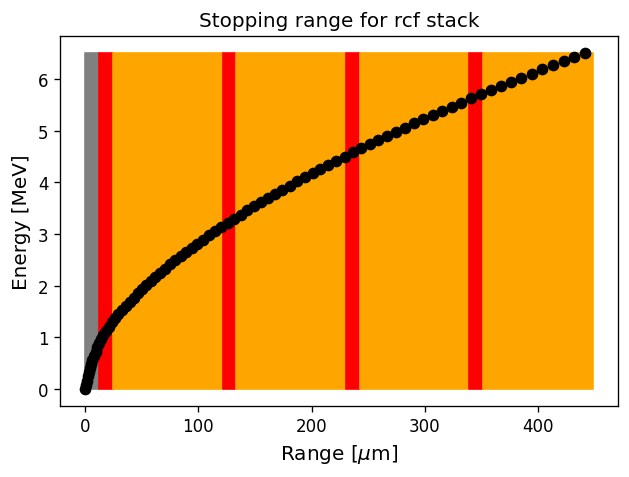

In [ ]:
t_en = 20
#print(stack_stop(s_params_test, 5))

#simulates how far a proton that is 5 MeV would travel across the stack
print(stack_stop(my_stack, 5))
#150 data points ranging from 0-10 MeV
en = np.linspace(0, 20, 250)
bands = energy_bands(my_stack, en, dx=0.00001)
#plots created stack
plot_bands(my_stack, en, bands, show_legend = False, name = "rcf stack")

In [ ]:
print(my_stack.total_thickness)
stack_stop(my_stack, 10)

0.04485


0.05000000000000001

In [ ]:
[1.3,3.3,4.5,5.6,6.5,7.3,8.0,8.7,9.4,10.0,10.6,11.2,11.7,12.2,12.7,13.2,13.7,14.1,14.6,15.0,15.4,15.9,16.3,16.7,17.1,17.4,17.8,18.2,18.6,18.9,19.3,19.6,20.0,20.3,20.6,21.0,21.3,21.6,21.9,22.3];

In [ ]:
bins = energy_bins(my_stack, en, bands)[1::2]
print(bins[:,1])

[1.3161313  3.32097785 4.64254129 5.71935411]


In [ ]:
[1.3161313  3.32231854 4.64473593 5.7220828 ]

[[ 0.90666389  1.3161313 ]
 [ 3.15008102  3.32097785]
 [ 4.51117805  4.64254129]
 [ 5.60856154  5.71935411]
 [ 6.55778242  6.65529764]
 [ 7.40895748  7.49796789]
 [ 8.18864615  8.2703746 ]
 [ 8.91308977  8.98962139]
 [ 9.59299384  9.66562672]
 [10.23638947 10.30526996]
 [10.84884996 10.91441062]]
